<a href="https://colab.research.google.com/github/MatheusABomfim/Mest_MBL2_ML_HTLV/blob/main/MEST_HTLV%2BMBL2%2BCLINICAL_Hyperparameters_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Loading data and packages**

**Libraries import**

In [1]:
# Import necessary libraries and packages
import os
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn.inspection import permutation_importance

# sklearn imports
from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedKFold,
    GridSearchCV, RepeatedStratifiedKFold, StratifiedShuffleSplit,
    learning_curve
)
from sklearn.ensemble import (
    ExtraTreesClassifier, RandomForestClassifier,
    AdaBoostClassifier, GradientBoostingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    recall_score, accuracy_score, roc_curve, auc, make_scorer,
    precision_score, f1_score
)
from sklearn.preprocessing import (
    LabelEncoder, MinMaxScaler, MaxAbsScaler, QuantileTransformer,
    RobustScaler, StandardScaler
)
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neural_network import MLPClassifier

# imbalanced-learn imports
from imblearn.metrics import geometric_mean_score
from imblearn.over_sampling import RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN

# joblib imports
from joblib import dump, load

# scikit-optimize imports
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# statsmodels imports
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# openpyxl imports
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows

# ipywidgets imports
from ipywidgets import interact, widgets

# shap imports
import shap
from sklearn.inspection import permutation_importance

# Ignore warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)


**Data import**

In [2]:
# Definindo variáveis globais para armazenar o DataFrame e o nome do dataset
df = pd.DataFrame()
dataset_name = None
X = None
y = None
balancing_method_selected = None  # Variável global para armazenar o método de balanceamento selecionado

# Função para listar arquivos CSV no diretório
def list_csv_files(directory):
    return [f for f in os.listdir(directory) if f.endswith('.csv')]

# Função para carregar e processar o dataset selecionado
def load_and_process_data(selected_file):
    global df, dataset_name, X, y
    dataset_name = selected_file
    file_path = os.path.join('..', 'datasets', 'feature_selection', dataset_name)

    if not os.path.exists(file_path):
        print(f"Erro: O arquivo '{file_path}' não foi encontrado.")
        return None

    df = pd.read_csv(file_path)

    # Convertendo 'Gênero' para valores numéricos
    if 'Gênero' in df.columns:
        df['Gênero'] = df['Gênero'].replace({'M': 0, 'F': 1})

    # Normalizando 'Idade_clinica'
    if 'Idade_clinica' in df.columns:
        scaler = MinMaxScaler()
        df['Idade_clinica'] = scaler.fit_transform(df[['Idade_clinica']])

    # Definindo X (features) e y (target)
    X = df.drop(columns=['PROVAVEL_HAM/TSP']) 
    y = df['PROVAVEL_HAM/TSP'] 

    print(f"Data Loaded and Processed Successfully! Dataset: {dataset_name}")
    return df.head()

# Função para definir o método de balanceamento selecionado
def set_balancing_method(method):
    global balancing_method_selected  # Declarando a variável como global
    balancing_method_selected = method  # Atribui o método selecionado à variável
    print(f"Método de balanceamento selecionado: {balancing_method_selected}")

# Função para aplicar o método de balanceamento selecionado
def apply_balancing(X, y):
    global balancing_method_selected
    if balancing_method_selected is None:
        print("Nenhum método de balanceamento foi selecionado.")
        return X, y

    if balancing_method_selected == 'Random Over Sampler':
        balancer = RandomOverSampler(random_state=42)
    elif balancing_method_selected == 'SMOTENC':
        # Ajusta dinamicamente as colunas categóricas para o SMOTENC
        categorical_columns = [col for col in X.columns if col != 'Idade_clinica']
        categorical_features = [X.columns.get_loc(col) for col in categorical_columns]
        balancer = SMOTENC(categorical_features=categorical_features, random_state=42)
    elif balancing_method_selected == 'Random Under Sampler':
        balancer = RandomUnderSampler(random_state=42)
    elif balancing_method_selected == 'Tomek Links':
        balancer = TomekLinks()
    else:
        print(f"Método de balanceamento desconhecido: {balancing_method_selected}")
        return X, y

    # Aplicando o método de balanceamento
    X_res, y_res = balancer.fit_resample(X, y)
    #print(f"Balanceamento aplicado com sucesso usando: {balancing_method_selected}")
    return X_res, y_res

# Definir o diretório onde os arquivos CSV estão localizados
directory = '../datasets/feature_selection/'

# Listar os arquivos CSV disponíveis no diretório
csv_files = list_csv_files(directory)

# Criar um widget de seleção com os arquivos listados
file_selector = widgets.Dropdown(
    options=csv_files,
    description='Select File:'
)

# Criar um widget para selecionar o método de balanceamento
balancing_methods = ['Random Over Sampler', 'SMOTENC', 'Random Under Sampler', 'Tomek Links']
method_selector = widgets.Dropdown(
    options=balancing_methods,
    description='Balancing Method:'
)

# Função interativa para carregar e processar o arquivo CSV selecionado
@interact(selected_file=file_selector)
def load_and_process_selected_file(selected_file):
    return load_and_process_data(selected_file)

# Função interativa para aplicar o método de balanceamento selecionado
@interact(selected_method=method_selector)
def apply_selected_balancing_method(selected_method):
    set_balancing_method(selected_method)
    X_res, y_res = apply_balancing(X, y)  # Aplica o balanceamento aos dados carregados
    print(f"Shape dos dados balanceados: {X_res.shape}, {y_res.shape}")

interactive(children=(Dropdown(description='Select File:', options=('df_Clinic_dataset_cat_2_ROS.csv', 'df_Cli…

interactive(children=(Dropdown(description='Balancing Method:', options=('Random Over Sampler', 'SMOTENC', 'Ra…

In [3]:
# List of model names that have been adjusted
model_names = ['DT', 'GB', 'LR', 'MLP', 'NB', 'RF', 'SVM', 'KNN', 'AB', 'LSVM']

# Directory where models and results are saved
model_dir = '../models/'

# Dictionary to store loaded templates
classifiers = {}

# Function for loading templates
def load_model(model_name):
    model_path = os.path.join(model_dir, f'best_{model_name}_model.joblib')

    if os.path.exists(model_path):
        # Load the model
        model = load(model_path)

        
        if isinstance(model, SVC):
            model.probability = True

        # Add the model to the classifiers dictionary using the corresponding name
        classifiers[model_name] = model

        print(f'Modelo {model_name} carregado com sucesso.')
    else:
        print(f'Arquivo para o modelo {model_name} não encontrado.')

# Iterate over all the model names and load them
for model_name in model_names:
    load_model(model_name)
definite_name = ['Decision Tree', 'Gradient Boosting', 'Logistic Regression', 'Multi-layer Perceptron', 'Naive Bayes', 'Random Forest', 'Support Vector Machine', 'K-Nearest Neighbors', 'AdaBoost', 'Linear SVM']


Modelo DT carregado com sucesso.
Modelo GB carregado com sucesso.
Modelo LR carregado com sucesso.
Modelo MLP carregado com sucesso.
Modelo NB carregado com sucesso.
Modelo RF carregado com sucesso.
Modelo SVM carregado com sucesso.
Modelo KNN carregado com sucesso.
Modelo AB carregado com sucesso.
Modelo LSVM carregado com sucesso.


In [4]:
# Instantiating RandomUnderSampler
rus = RandomUnderSampler()

# Apply RandomUnderSampler to data
X_resampled, y_resampled = rus.fit_resample(X, y)

# Creating a new DataFrame with the resampled data
df_ = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['PROVAVEL_HAM/TSP'])], axis=1)

# ...

y = df_['PROVAVEL_HAM/TSP'] # Target variable as a NumPy array
X = df_.drop('PROVAVEL_HAM/TSP', axis=1)  # Predictor variables as a NumPy array

In [5]:
# Find the index of the first value 1 (target)
first_one_index = np.where(y == 1)[0][0] if np.any(y == 1) else -1  
print(first_one_index)  

24


# Waterfall

HAM/TSP

Importância das Características do modelo Decision Tree


ValueError: Image size of 1091919x864 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1200x900 with 3 Axes>

Importância das Características do modelo Gradient Boosting


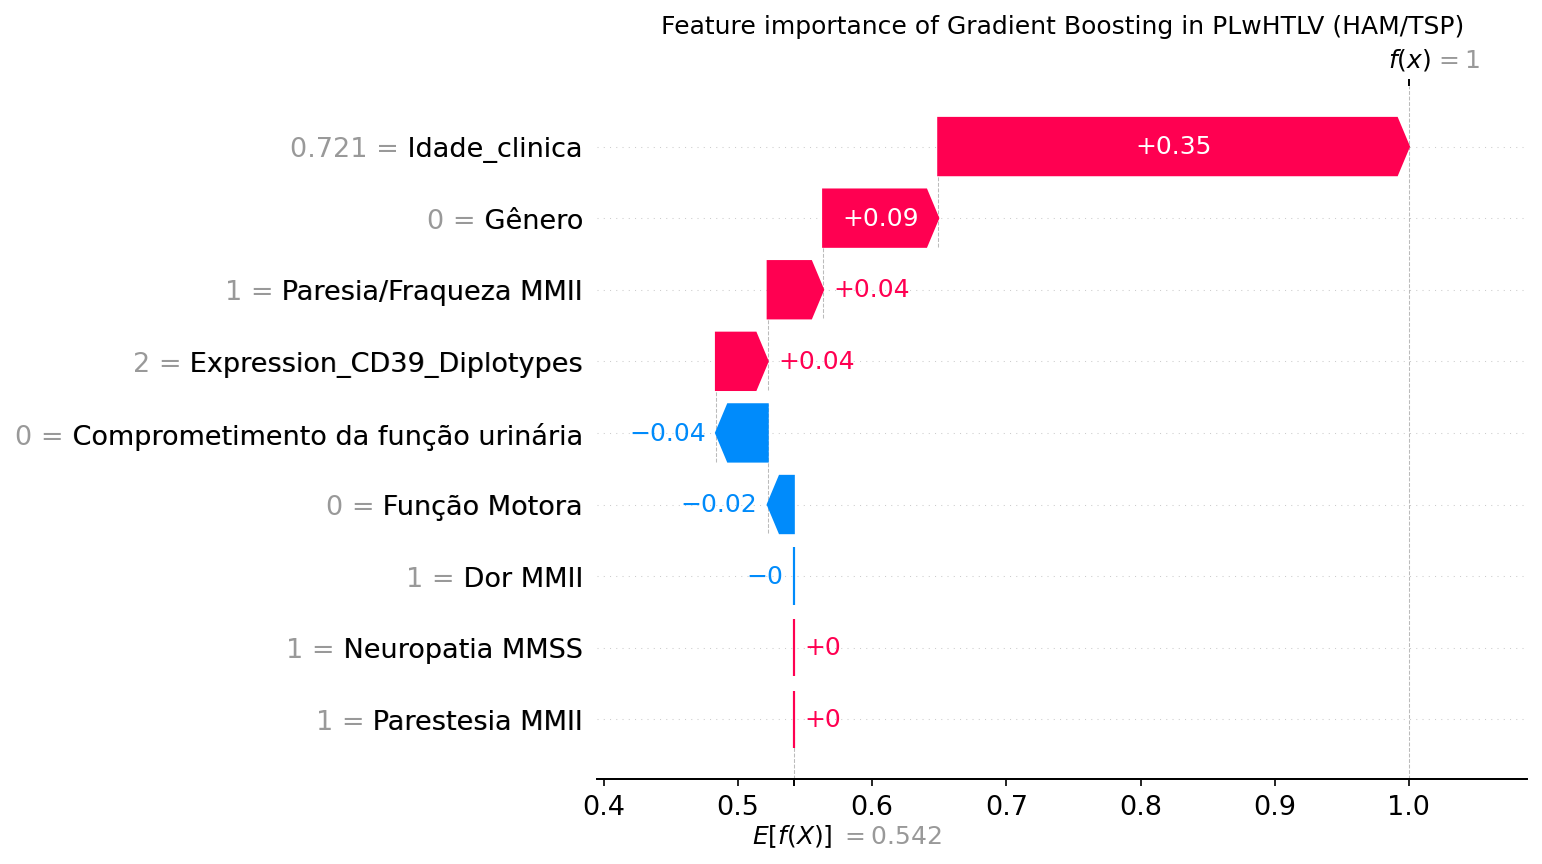

Importância das Características do modelo Logistic Regression


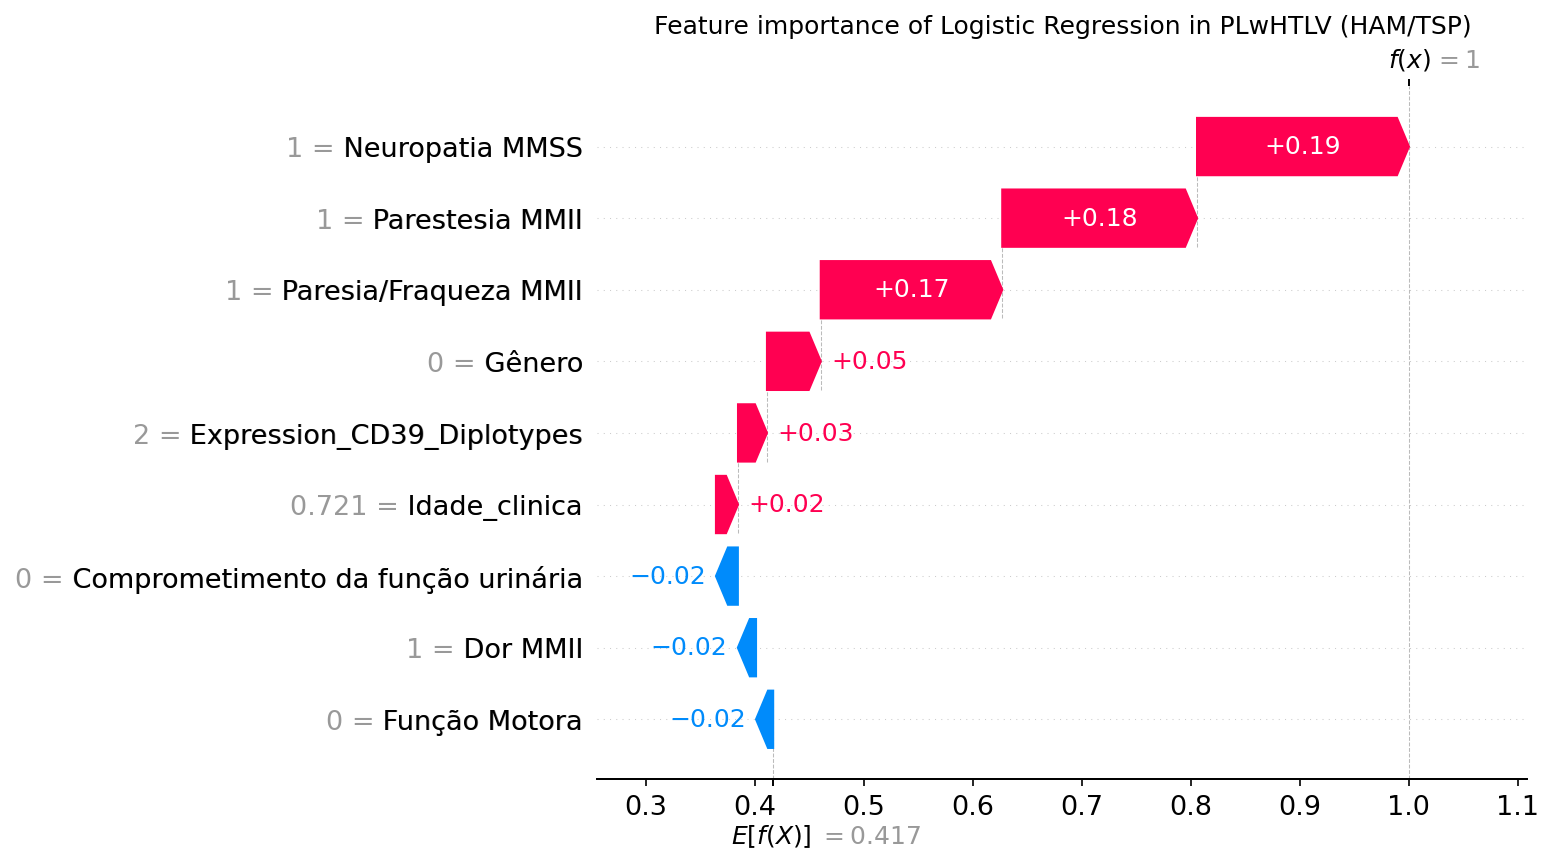

Importância das Características do modelo Multi-layer Perceptron


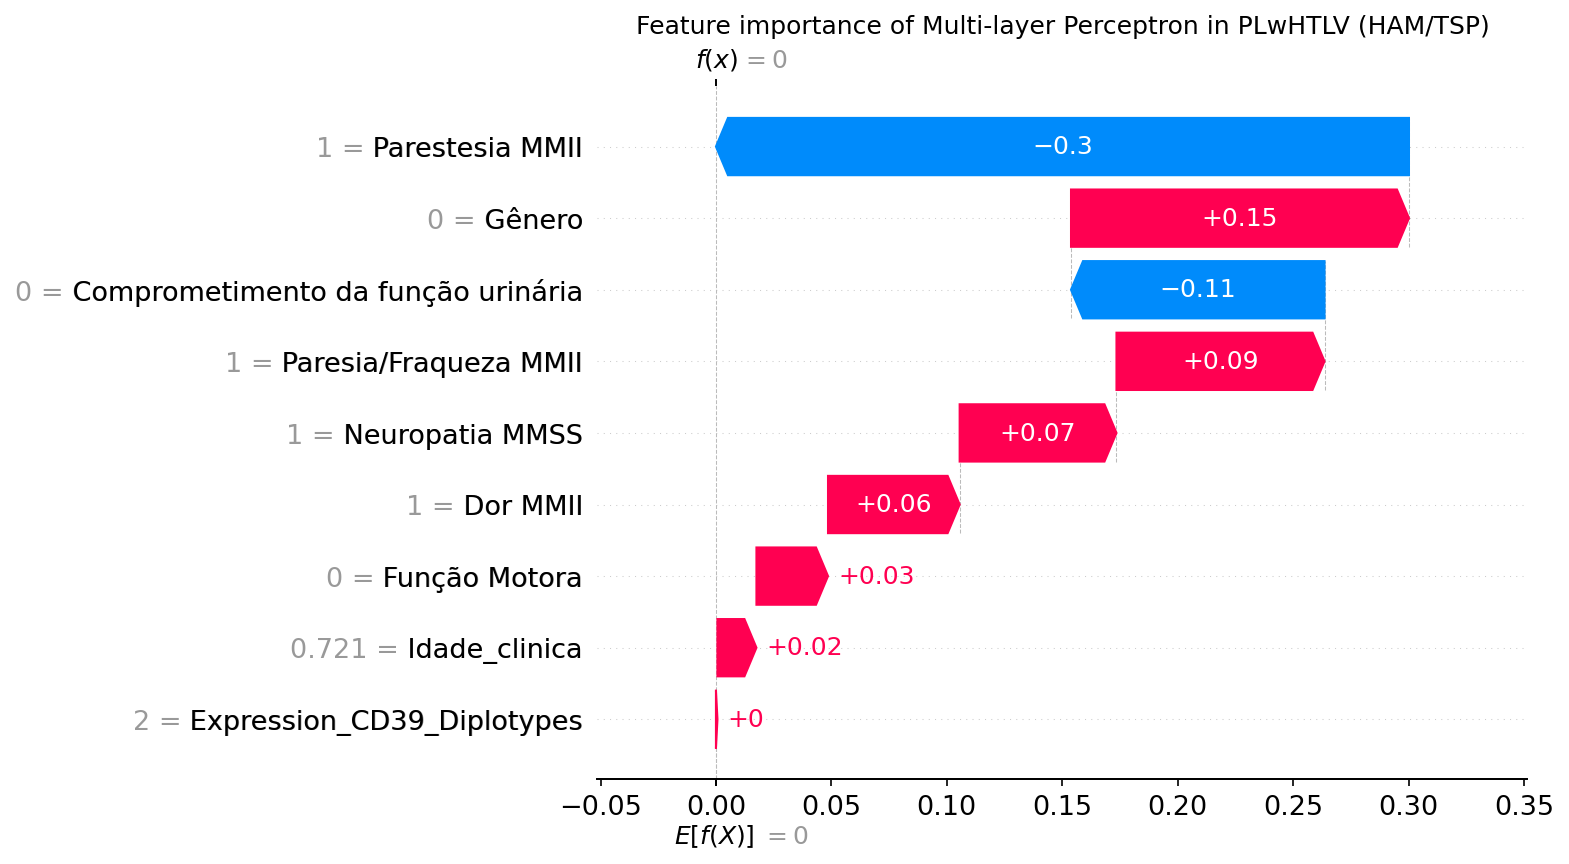

Importância das Características do modelo Naive Bayes


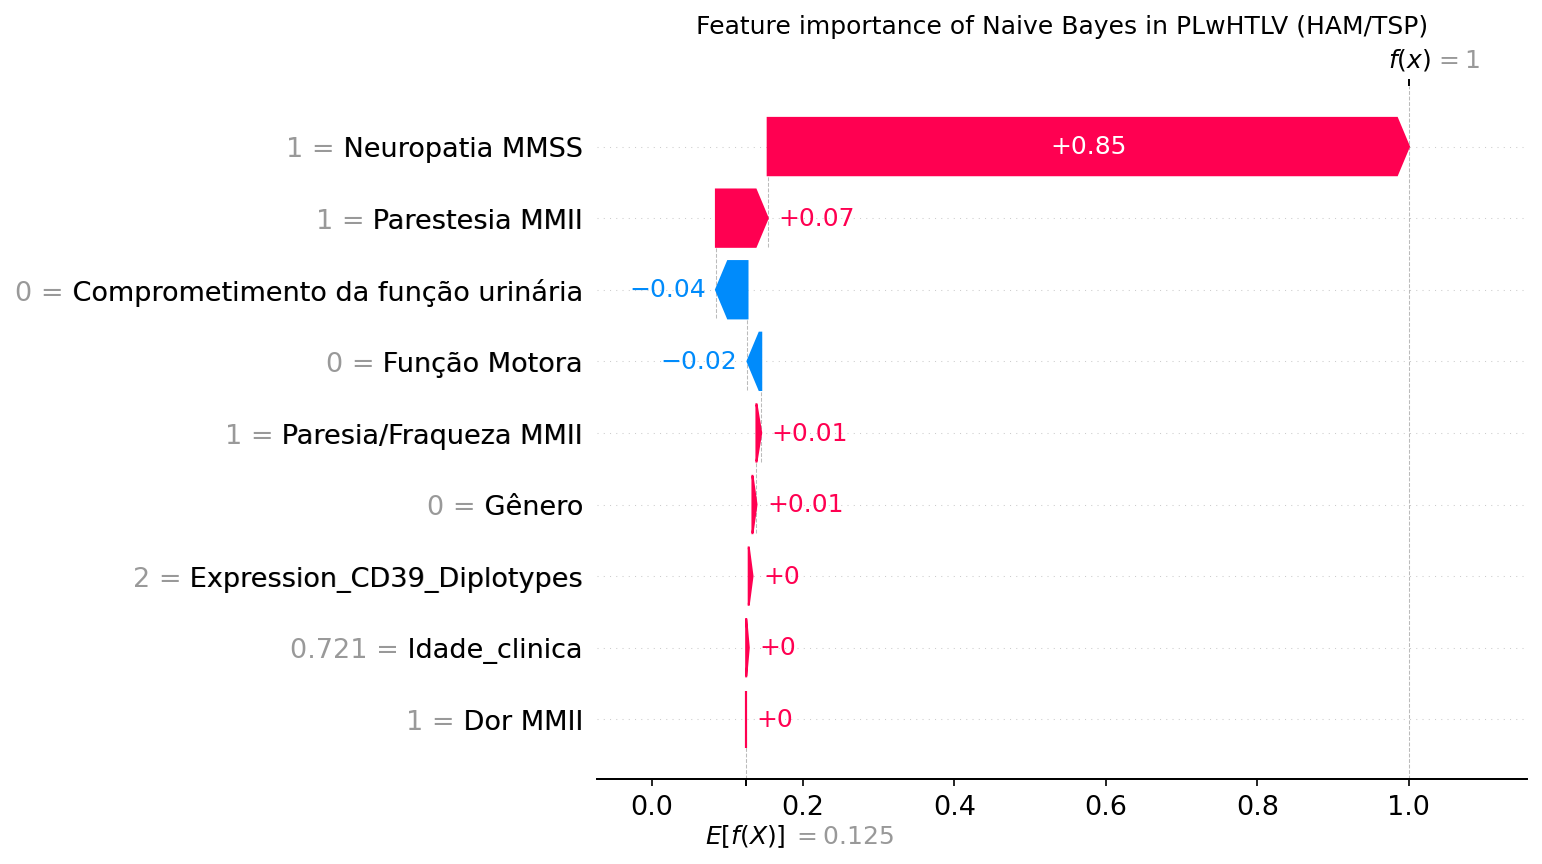

Importância das Características do modelo Random Forest


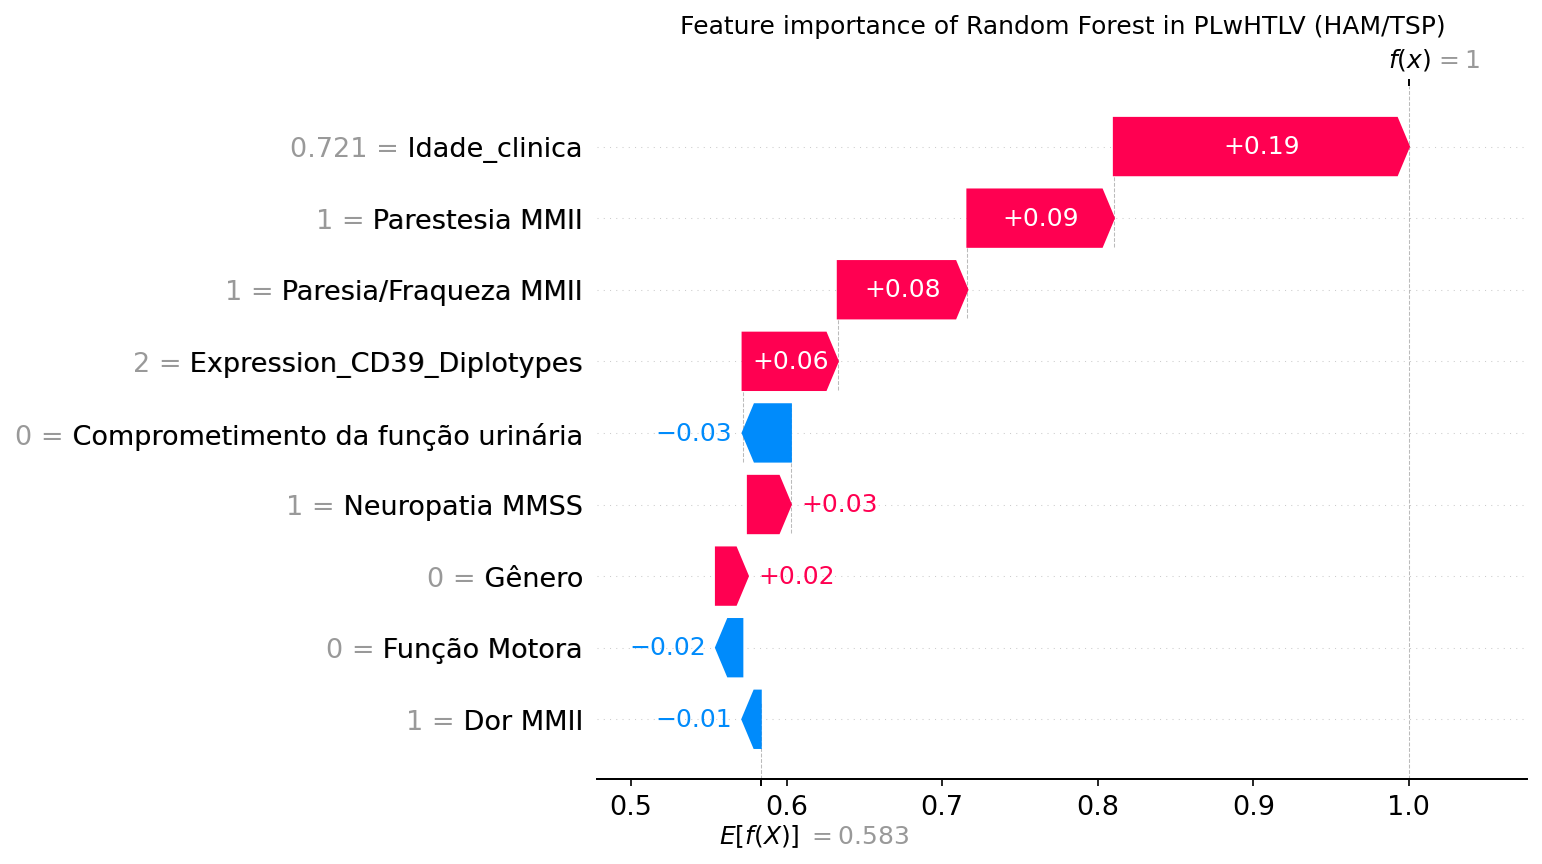

Importância das Características do modelo Support Vector Machine


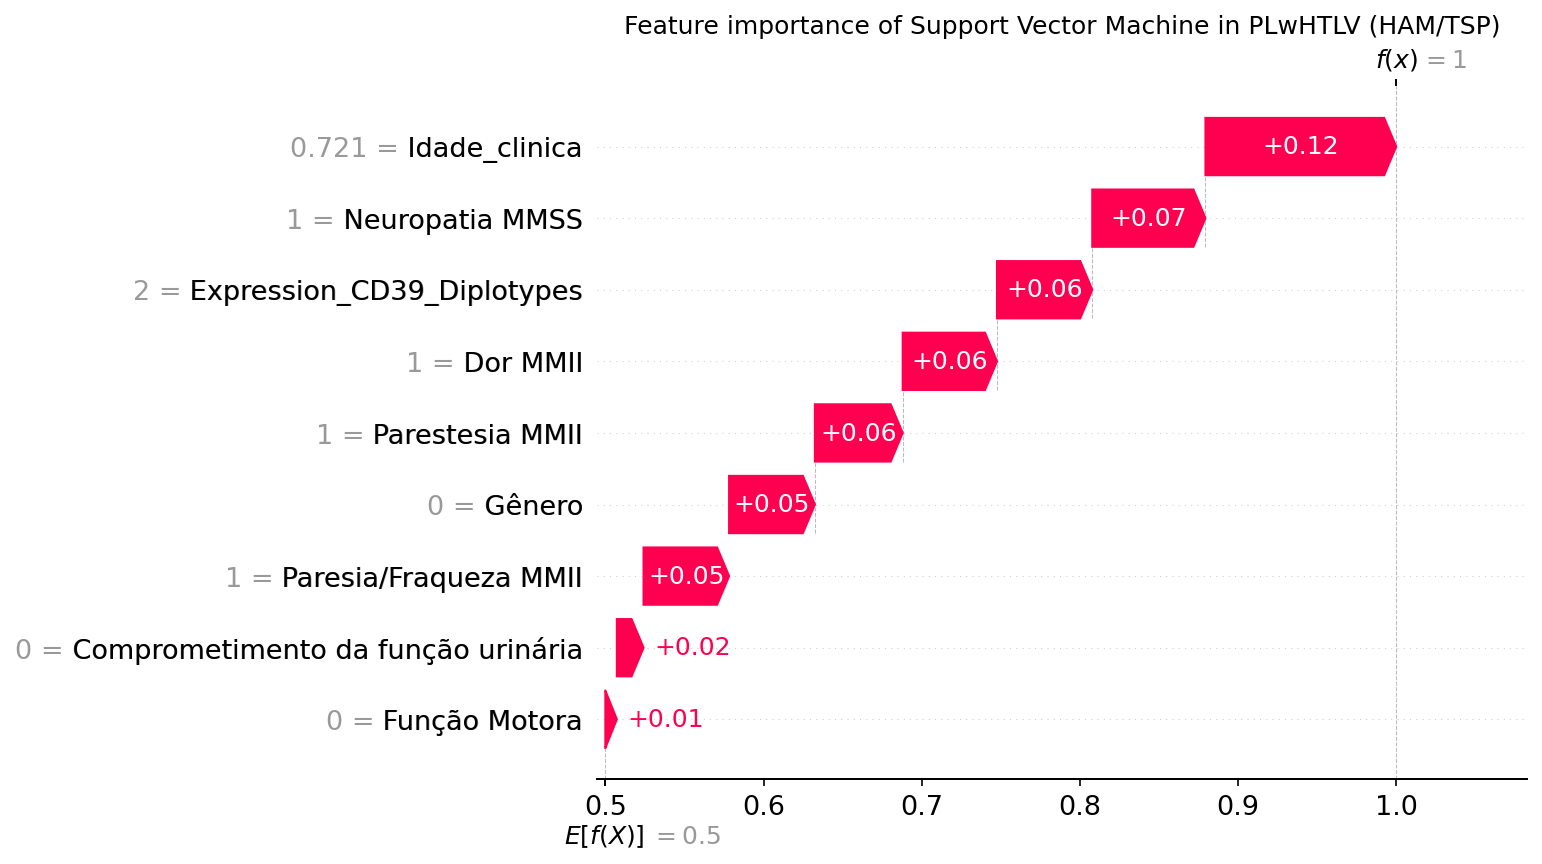

Importância das Características do modelo K-Nearest Neighbors


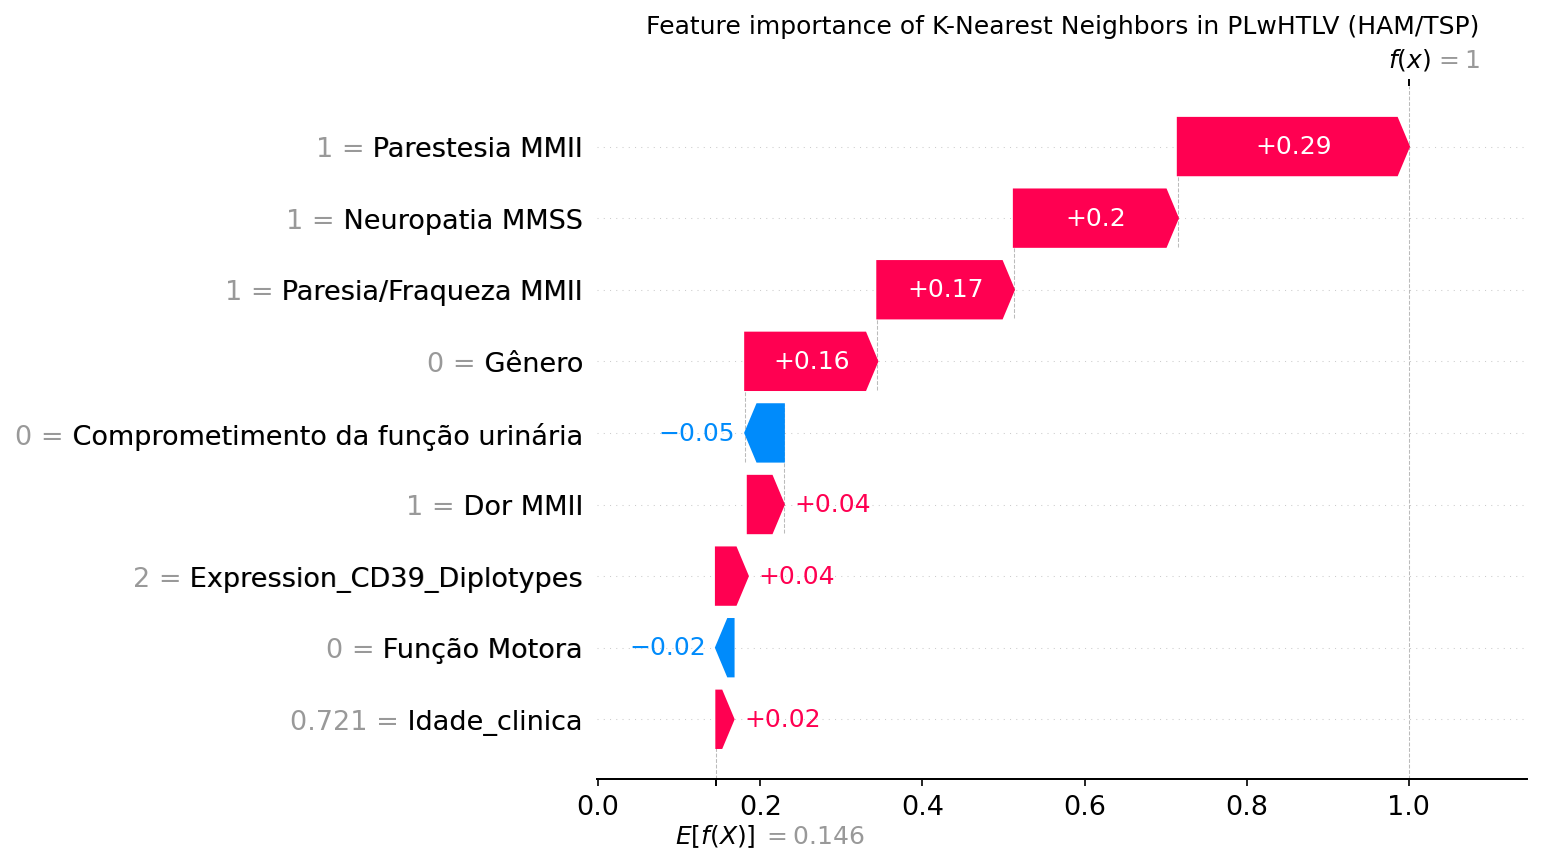

Importância das Características do modelo AdaBoost


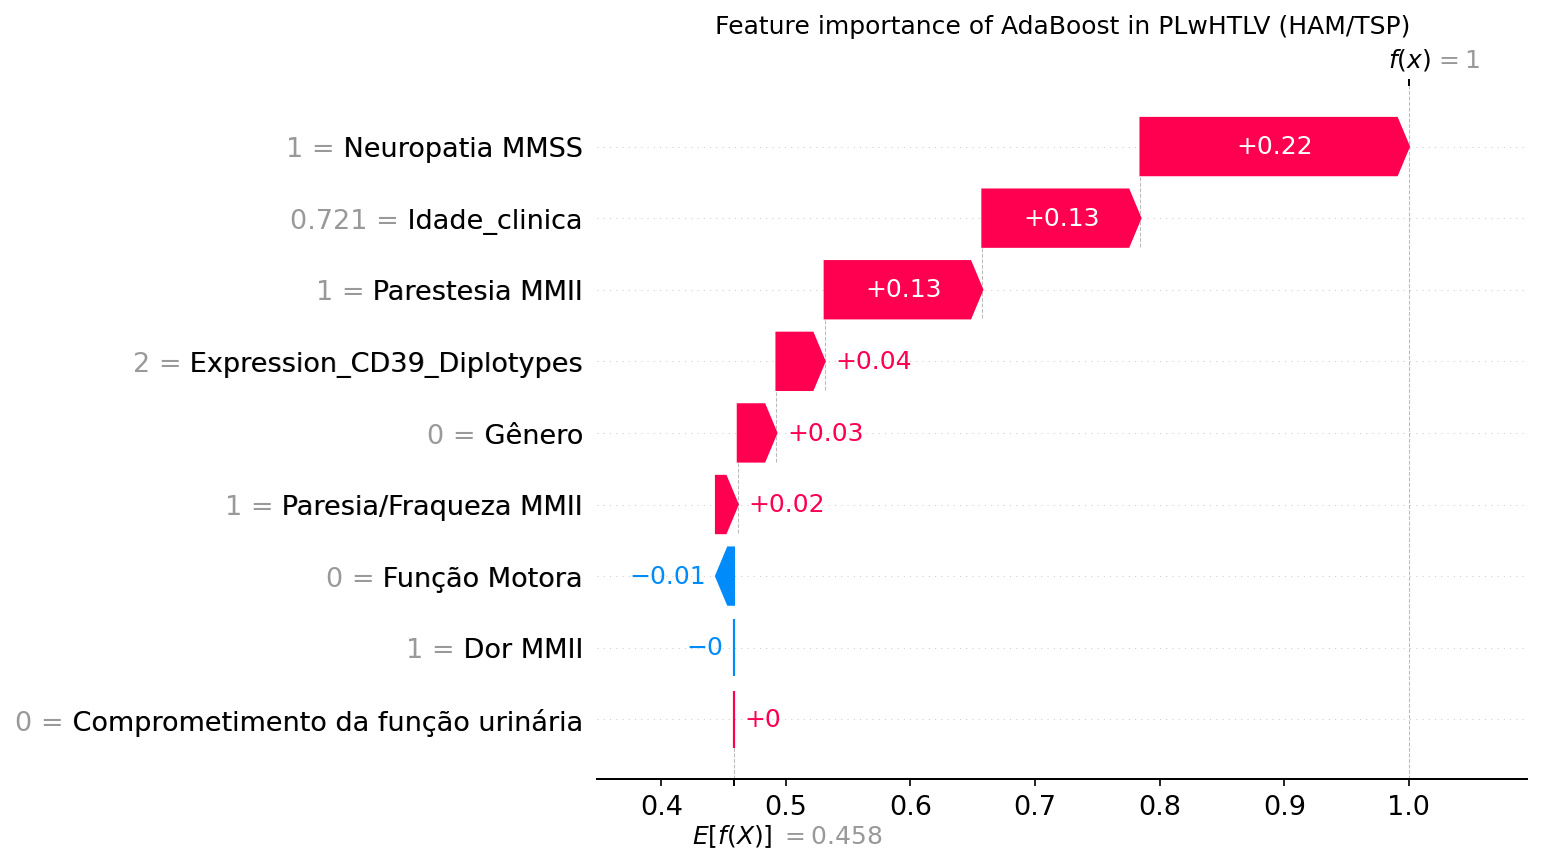

Importância das Características do modelo Linear SVM


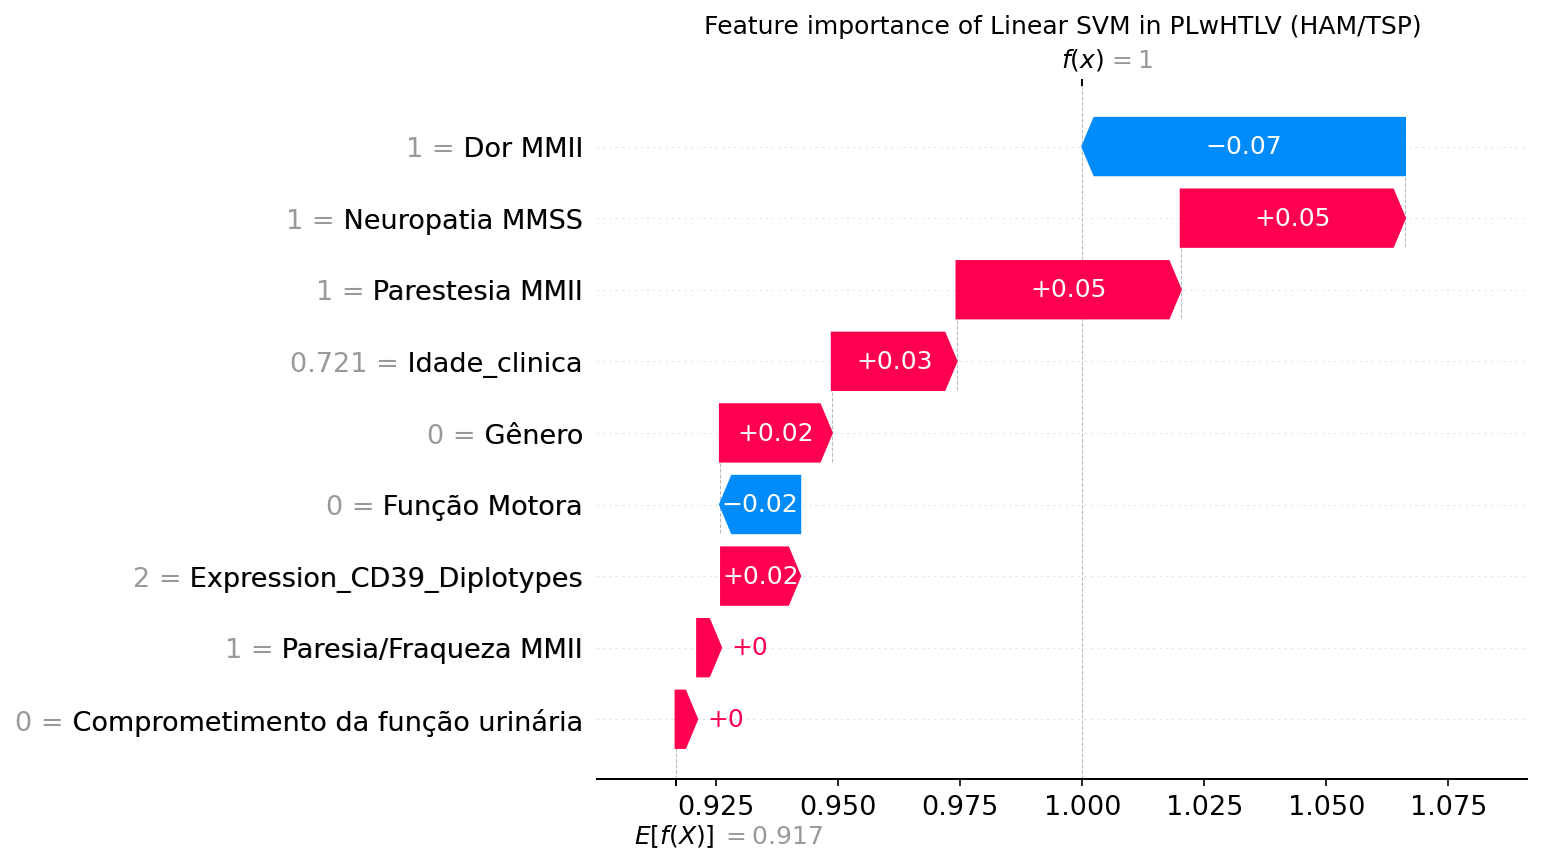

In [13]:
for model_name, item in classifiers.items():
    # Treinando o modelo
    item.fit(X, y)

    # Criando o explicador SHAP
    explainer = shap.Explainer(item.predict, X)
    shap_values = explainer(X)

    # Nome completo do modelo
    full_name = definite_name[model_names.index(model_name)]

    print(f'Importância das Características do modelo {full_name}')

    # Ajustando o tamanho do gráfico
    plt.figure(figsize=(16, 12), dpi=150)  # Reduzindo tamanho e DPI

    # Gráfico waterfall com limite de características
    shap.plots.waterfall(shap_values[24], max_display=10, show=False)

    # Título
    plt.title(f'Feature importance of {full_name} in PLwHTLV (HAM/TSP)')

    # Mostrar o gráfico
    plt.show()


NON-HAM/TSP

Importância das Características do modelo Decision Tree


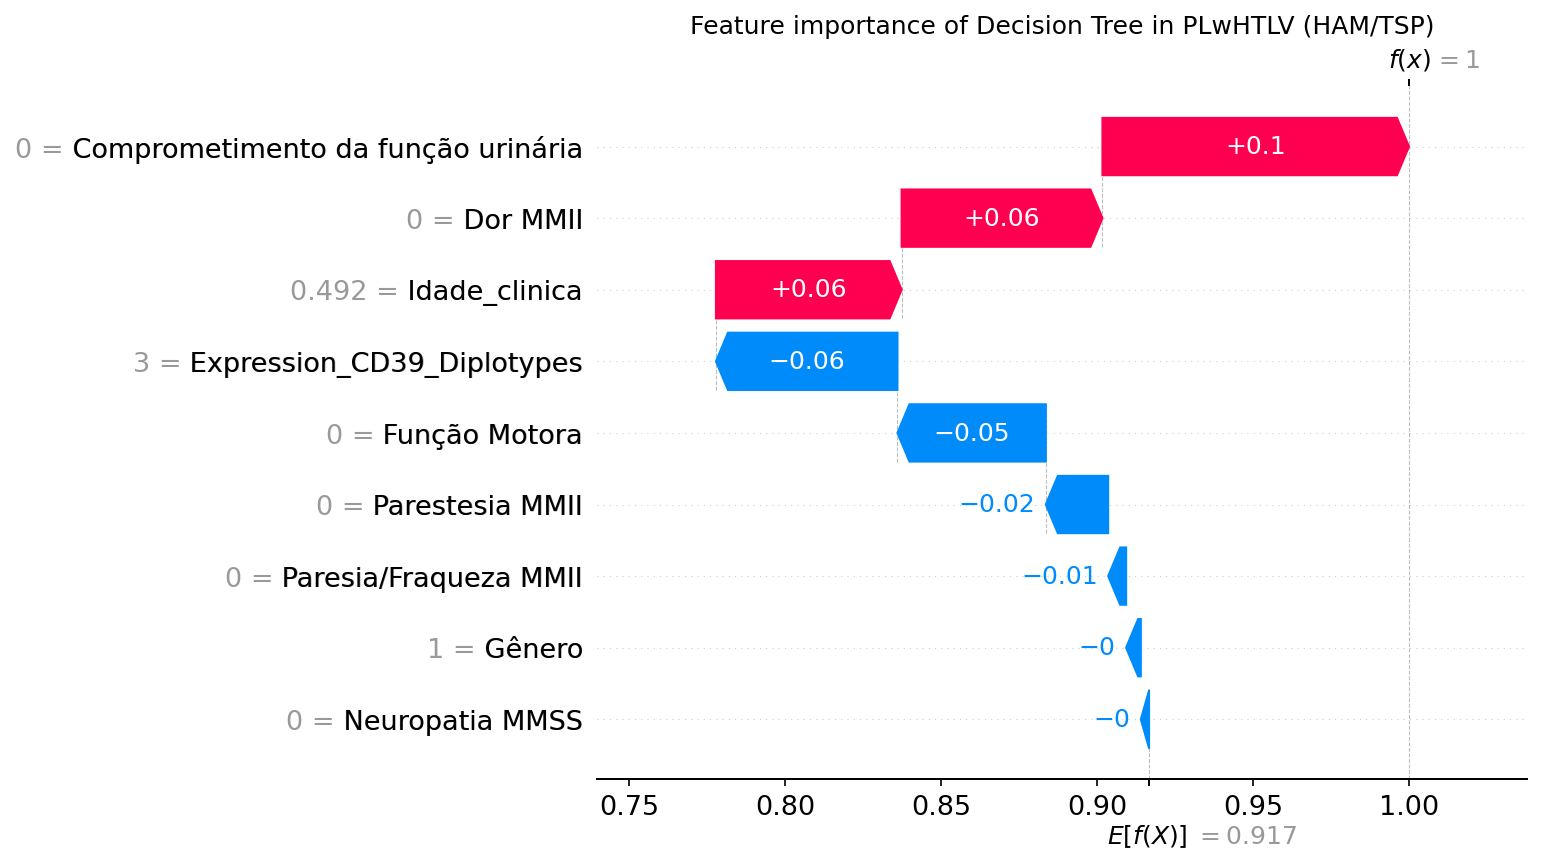

Importância das Características do modelo Gradient Boosting


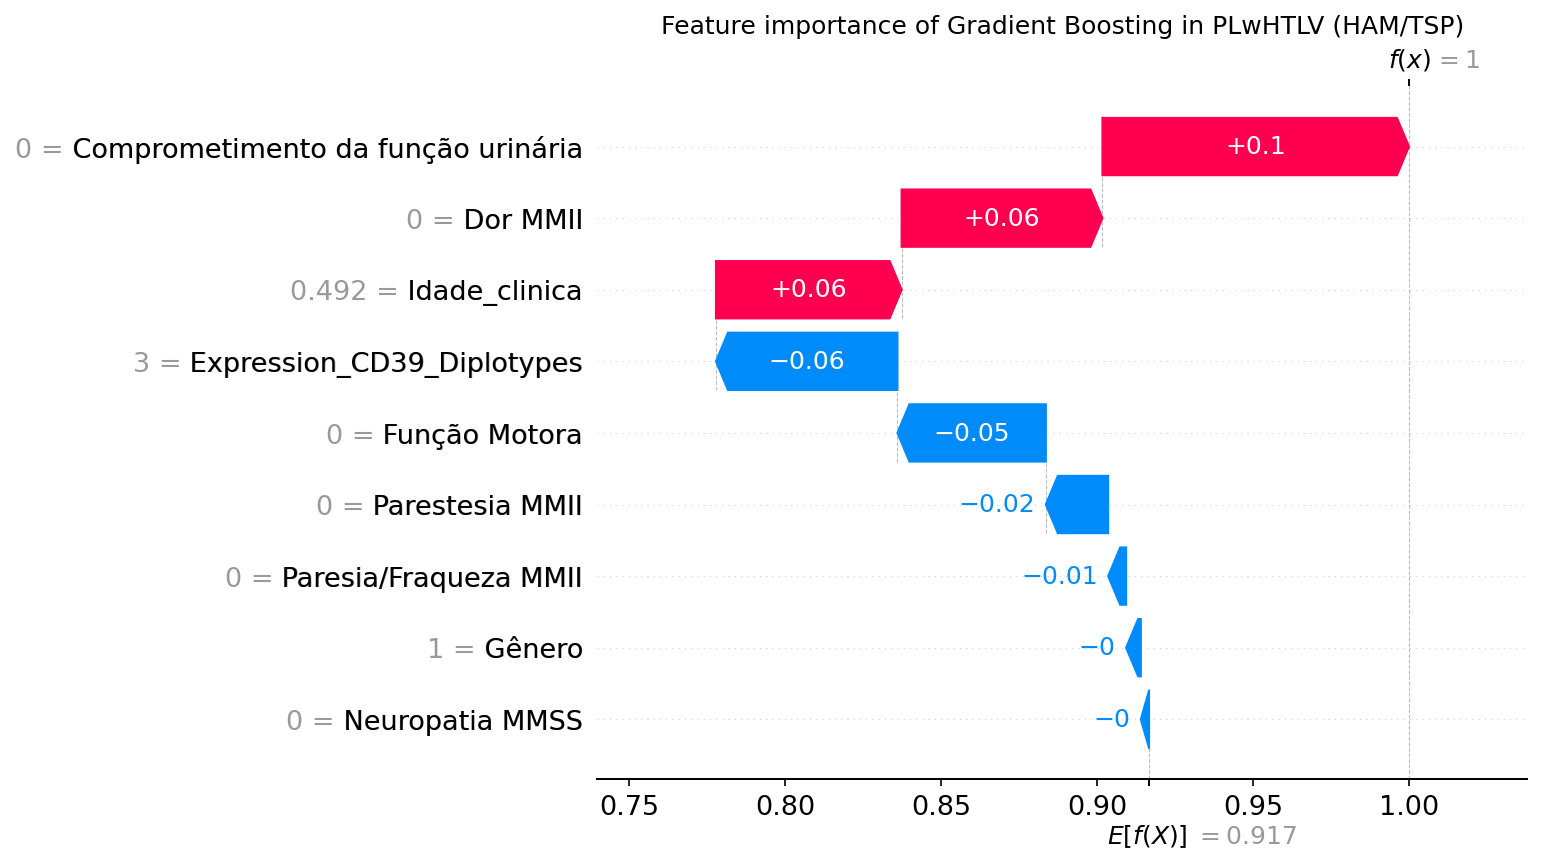

Importância das Características do modelo Logistic Regression


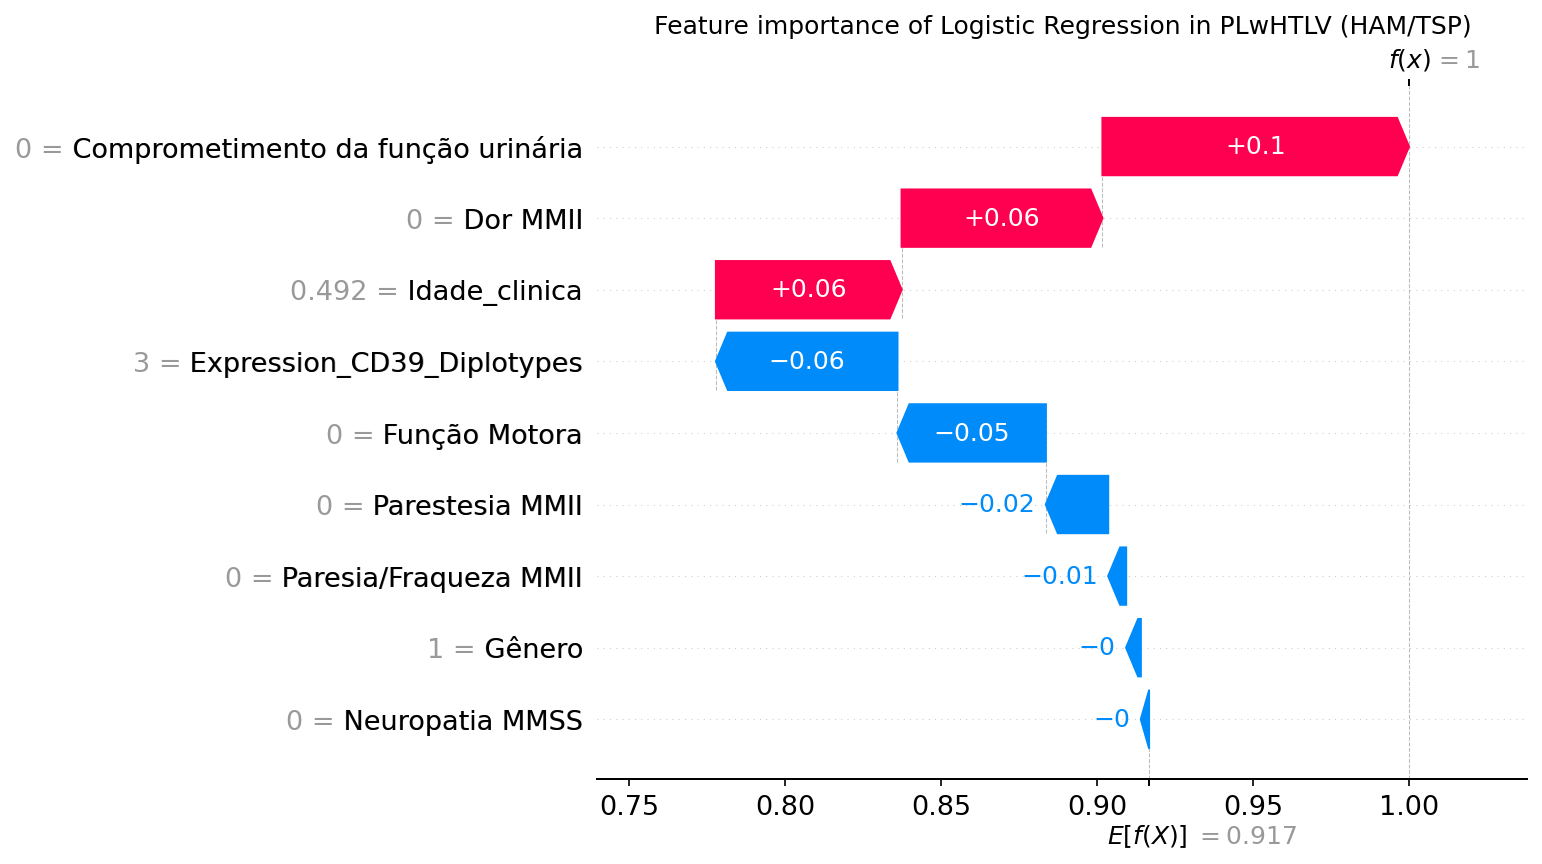

Importância das Características do modelo Multi-layer Perceptron


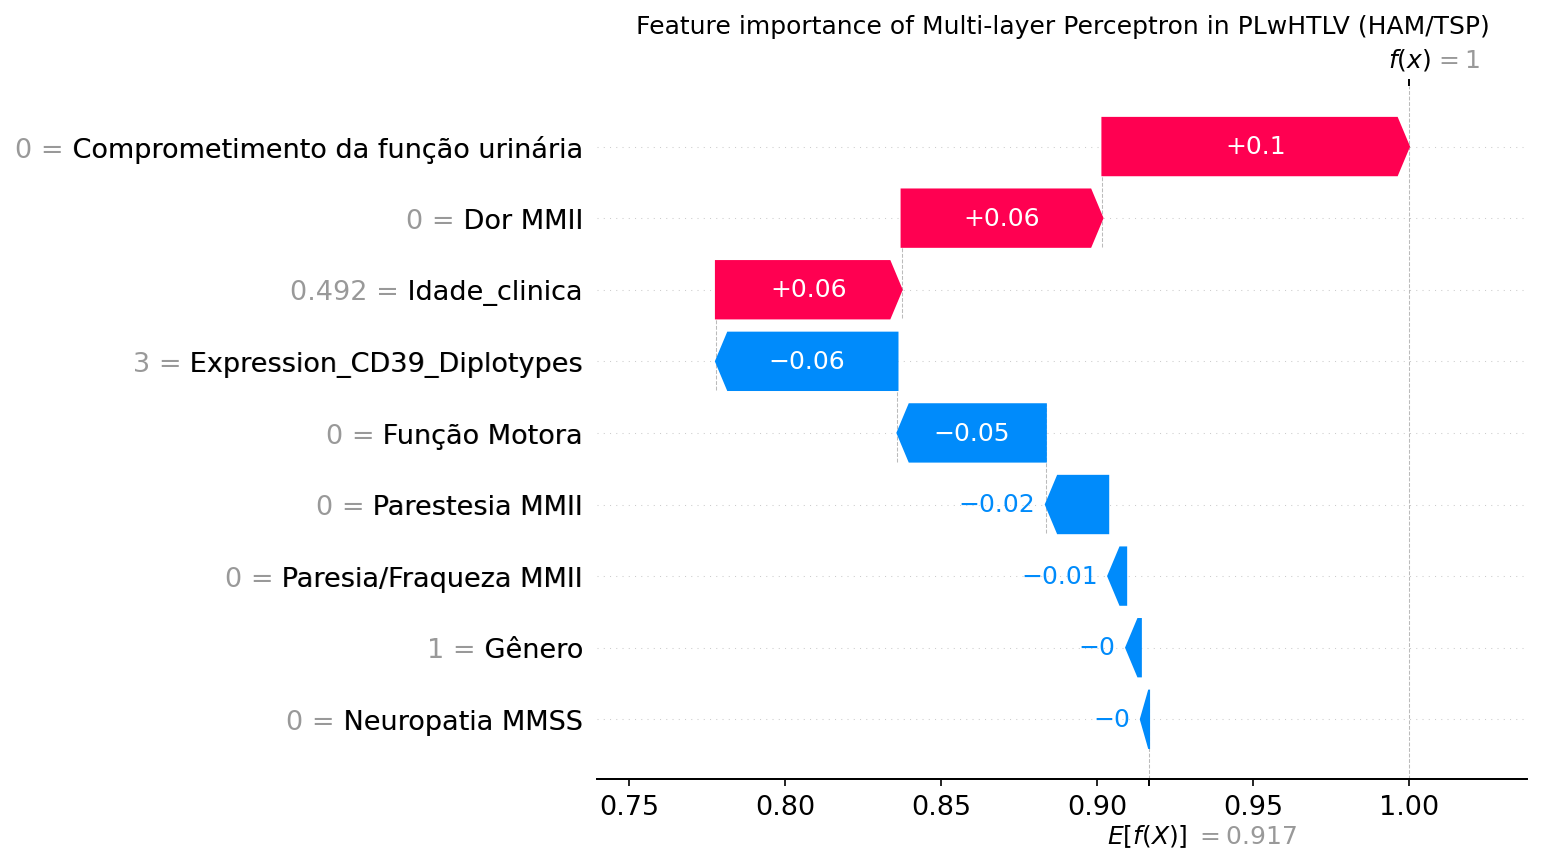

Importância das Características do modelo Naive Bayes


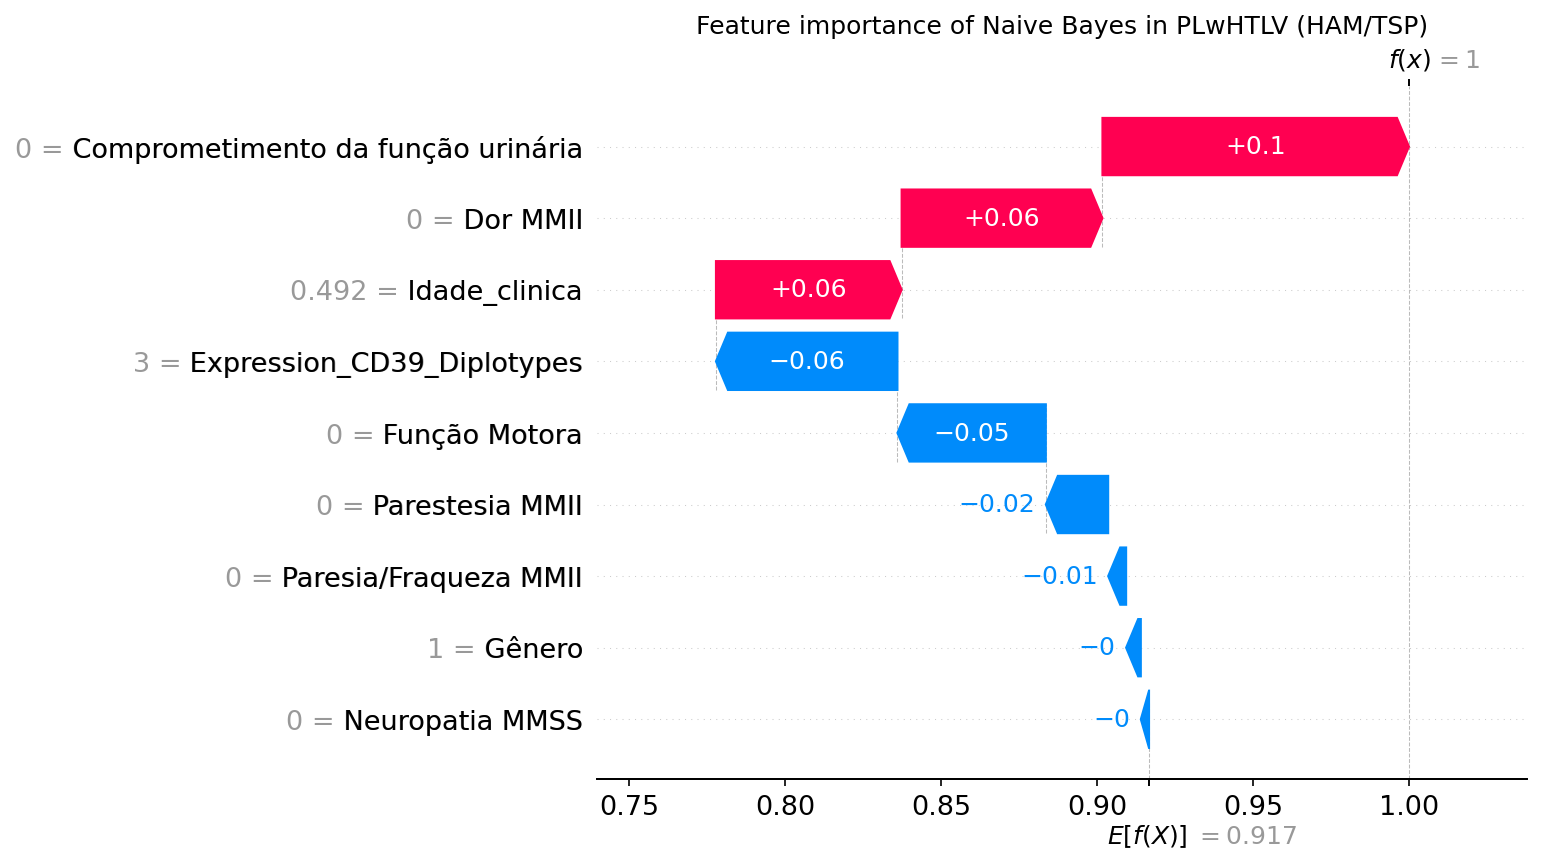

Importância das Características do modelo Random Forest


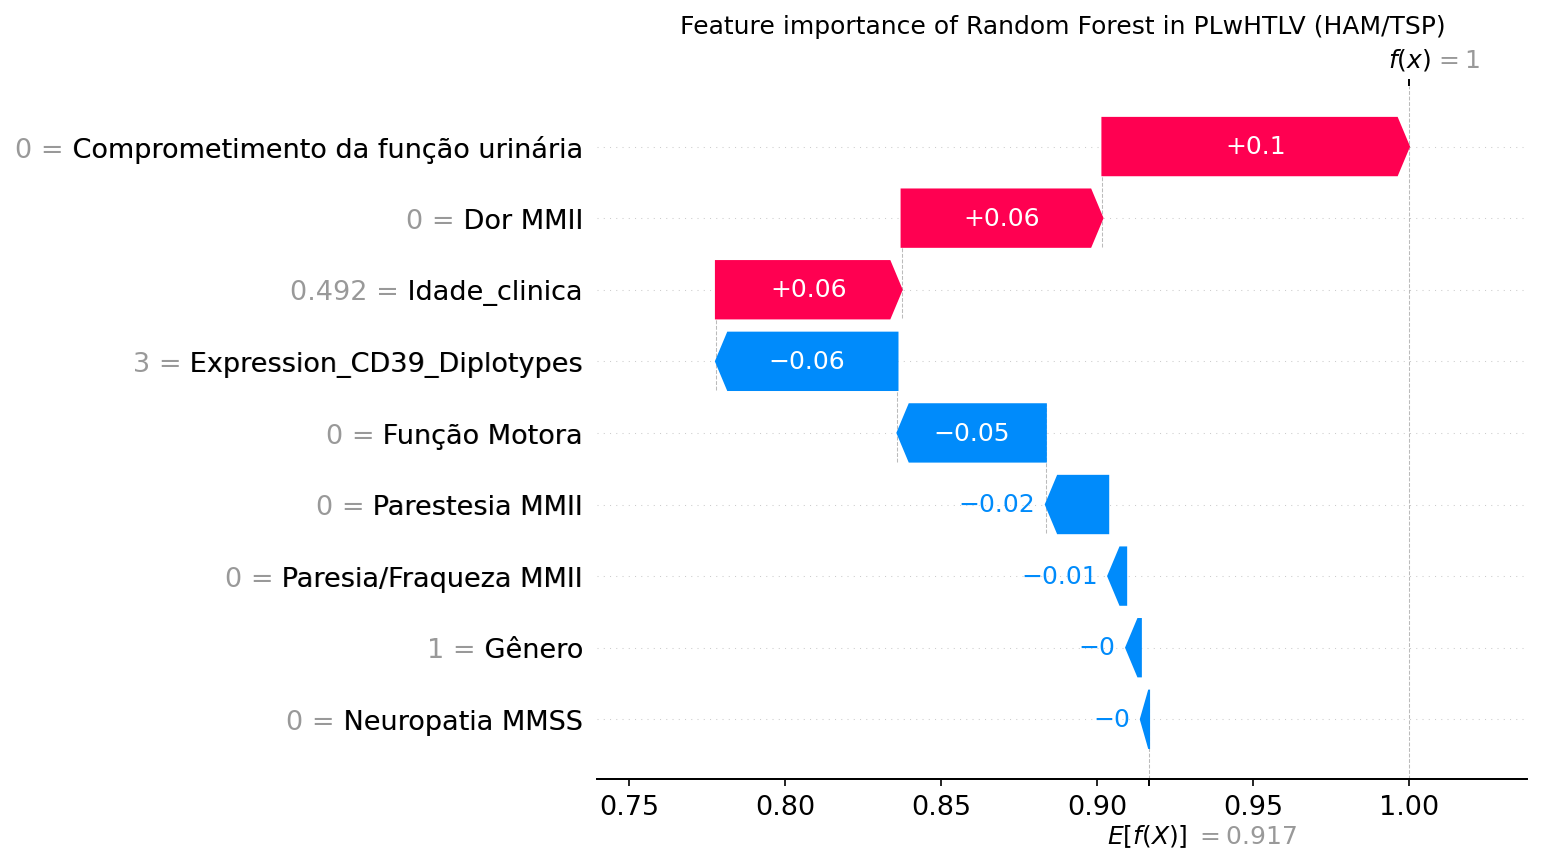

Importância das Características do modelo Support Vector Machine


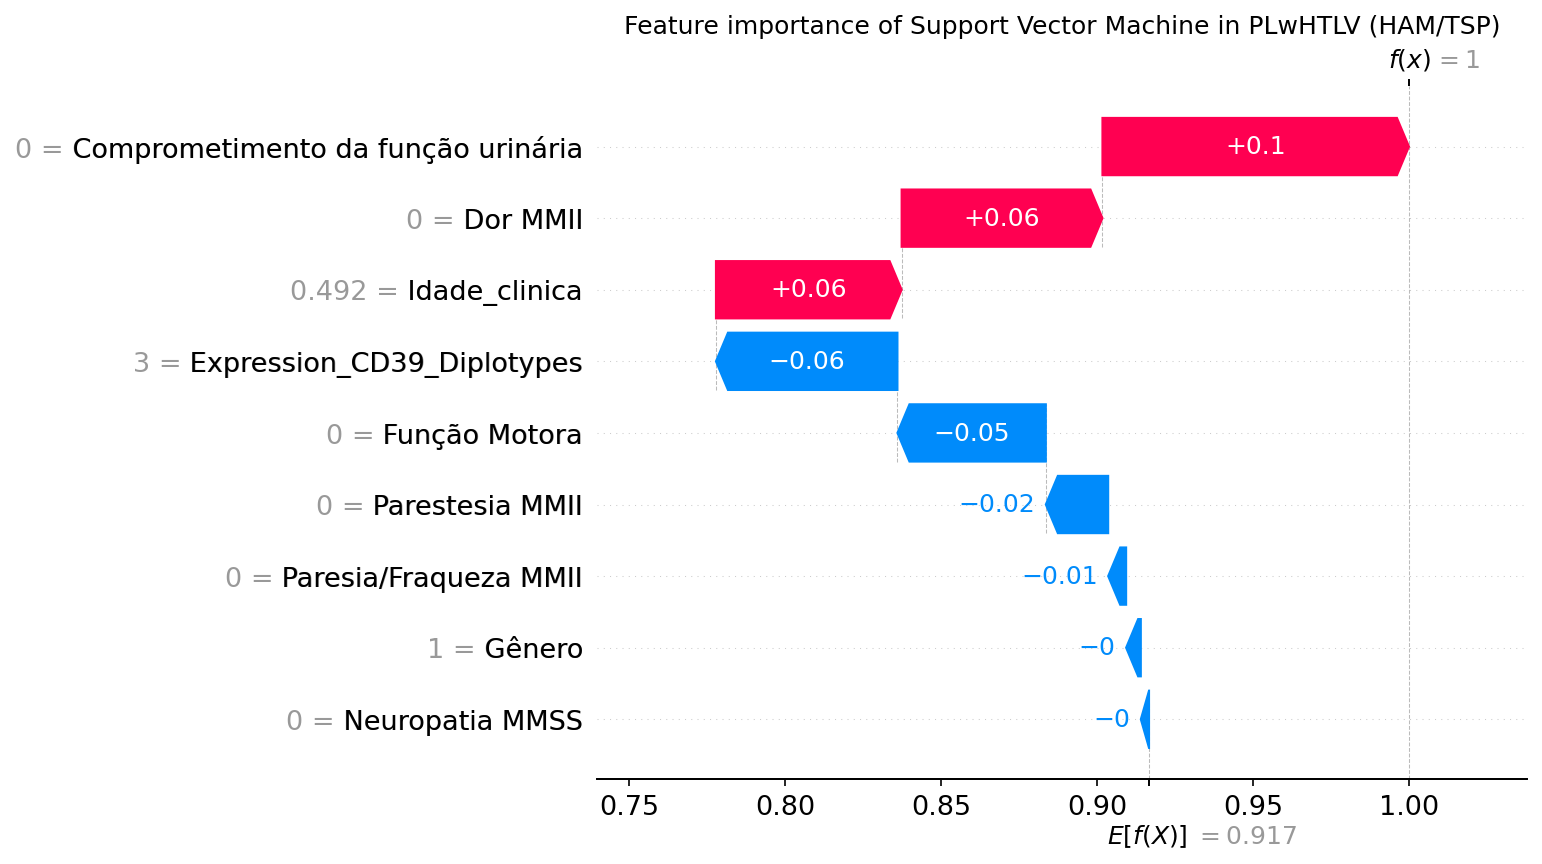

Importância das Características do modelo K-Nearest Neighbors


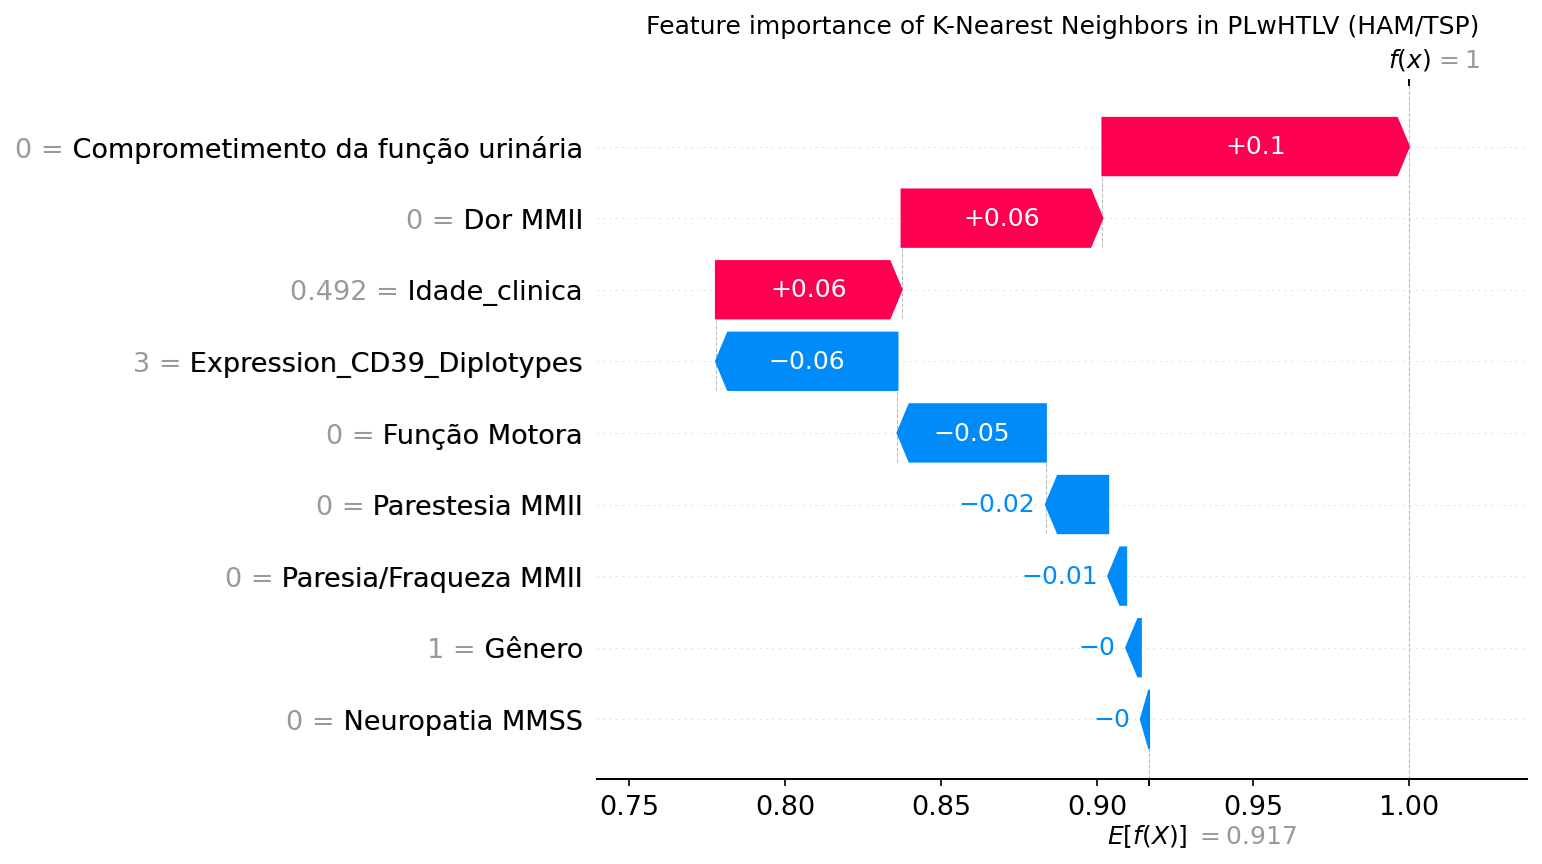

Importância das Características do modelo AdaBoost


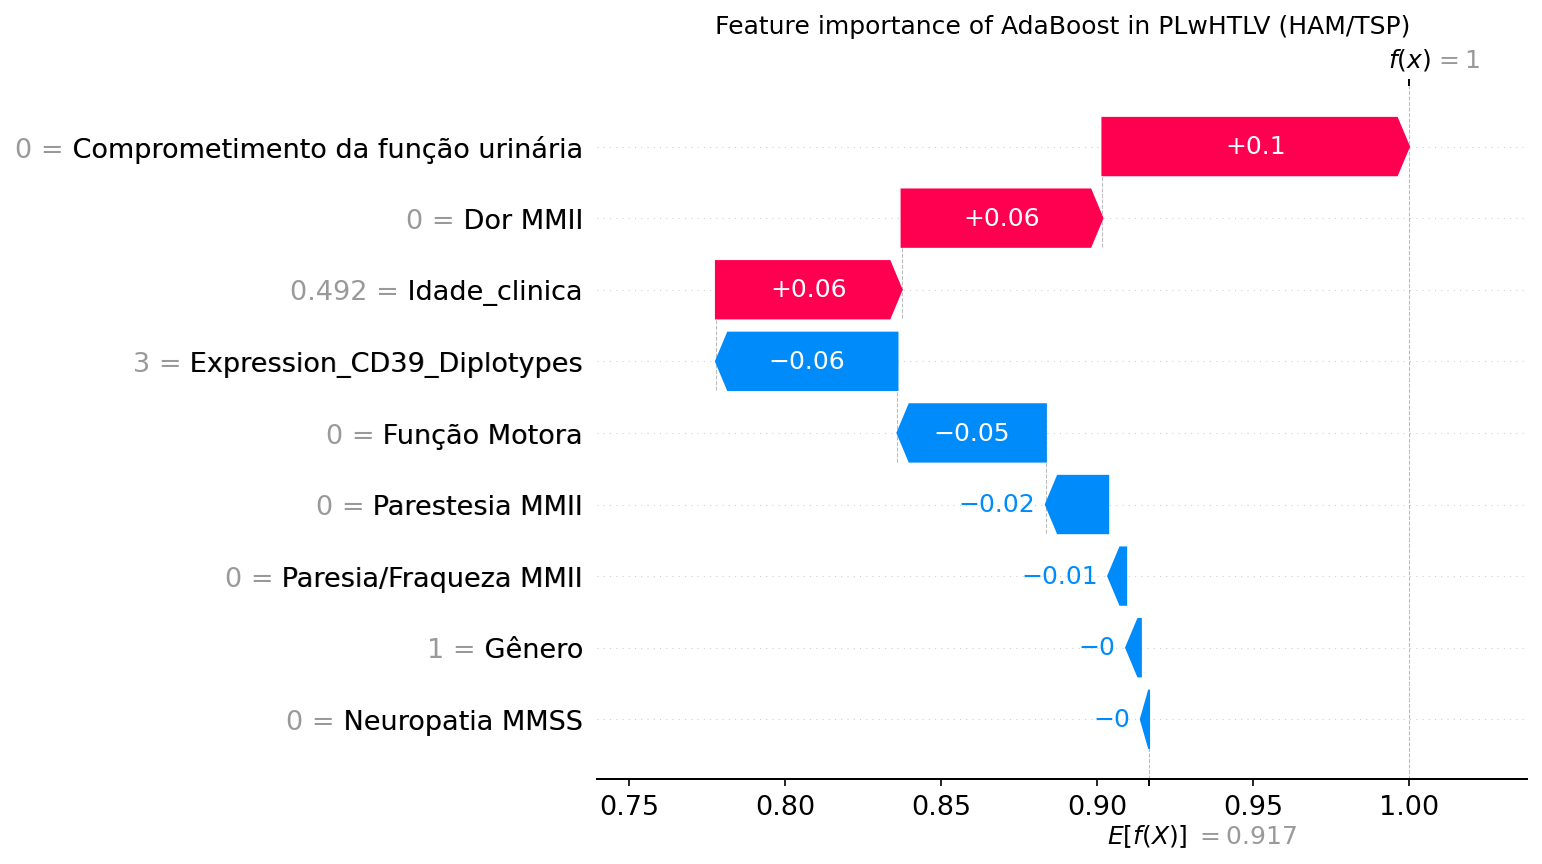

Importância das Características do modelo Linear SVM


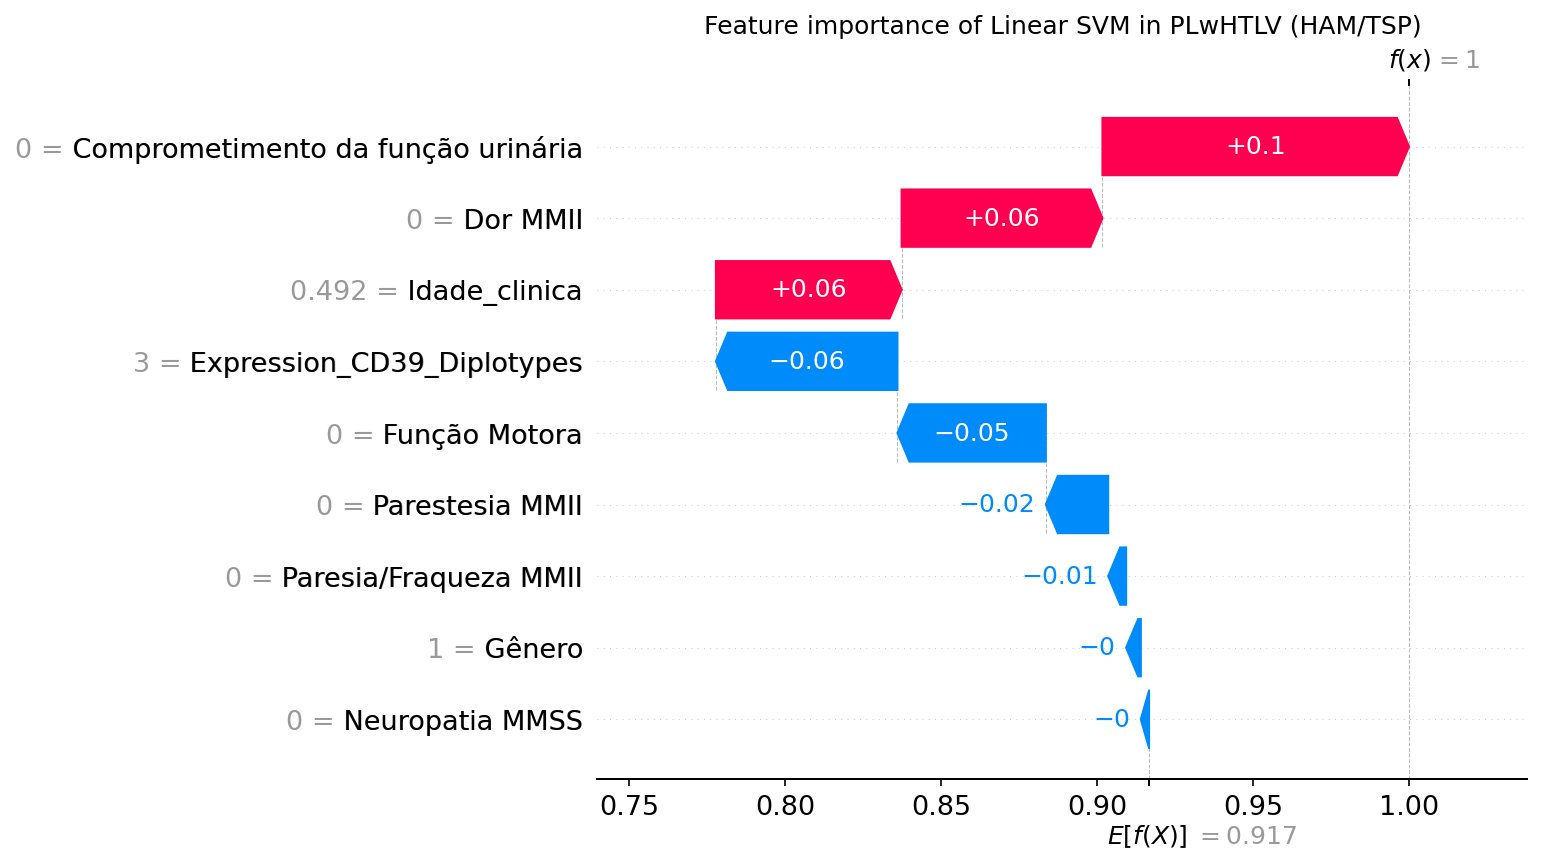

In [15]:
# Training the classifiers
for model_name, item in classifiers.items():
    # Training model
    item.fit(X, y)

    # Fits the explainer
    explainer = shap.Explainer(item.predict, X)
    # Calculates the SHAP values - It takes some time

    # Get the corresponding full name from definite_name
    full_name = definite_name[model_names.index(model_name)]

    print(f'Importância das Características do modelo {full_name}')

    # Ajustando o DPI para evitar erro de renderização
    plt.figure(figsize=(10, 6), dpi=150)  # Reduzindo o DPI da imagem

    shap.plots.waterfall(shap_values[23], show=False)

    # Set the title with the full model name
    plt.title(f'Feature importance of {full_name} in PLwHTLV (HAM/TSP)')

    # Show the plot
    plt.show()


# Forceplot + Scatterplot

In [16]:
results_dir = '../results/'

# Make sure the directory exists
os.makedirs(results_dir, exist_ok=True)

for model_name, item in classifiers.items():
    # Train the model
    item.fit(X, y)

    # Adjust the explainer
    explainer = shap.Explainer(item.predict, X)
    # Calculate SHAP values
    shap_values = explainer(X)

    print(f'Importância das Características do modelo {model_name}')
    for i in range(len(X)):
        shap_plot = shap.plots.force(shap_values[23], matplotlib=True, show=False, figsize=(15, 5), text_rotation=20)
        plt.savefig(os.path.join(results_dir, f'{model_name}_force_plot_{i}.png'))
        plt.close()
        break 

    # Show saved plots
    print("Versão detalhada:")
    shap.summary_plot(shap_values, X, show=False)
    plt.savefig(os.path.join(results_dir, f'{model_name}_summary_plot.png'))
    plt.close()

Importância das Características do modelo DT
Versão detalhada:
Importância das Características do modelo GB
Versão detalhada:
Importância das Características do modelo LR
Versão detalhada:
Importância das Características do modelo MLP
Versão detalhada:
Importância das Características do modelo NB
Versão detalhada:
Importância das Características do modelo RF
Versão detalhada:
Importância das Características do modelo SVM
Versão detalhada:
Importância das Características do modelo KNN
Versão detalhada:
Importância das Características do modelo AB
Versão detalhada:
Importância das Características do modelo LSVM
Versão detalhada:
